#### Introduction
When fitting a GAM it is important to ensure the model is capturing the trend and not
surrounding noise. When fitting long term trends, this approach becomes even more important.
Three model selection criteria will be used here to optimise the model. They are GCV 
(General Cross Validation), AIC (Akaike Information Criterion ) and BIC (Bayesian 
Information Criterion). All three criteria reward goodness of fit, but penalise 
complexity (measured by the effective degrees of freedom). For all three criteria, 
the model with the lowest score is considered optimal.

#### Aim 
To identify the optimal model selection criteria for fitting species relative
abundance time series data.

#### Workflow
1) First a species subset is extracted by filtering the main dataframe 'ukbms'. 
2) The data is split into train/test sets using 'train_test_split'.
3) Training data is used to fit the model.
4) The optimal model is selected using one of three criteria (GCV, AIC or BIC).
5) The optimal model is then used to predict the test data.
6) Response test set data is plotted on same graph as explanatory test set data (in log 
form) to assess overall fit.
7) The model predictions for each selection criteria are then plotted on the same 
linegraph for visual comparison (both in log form and back transformed). 
8) edof (effective degrees of freedom), MAE (mean Absolute Error) and RMSE (Root mean 
Square Error) are also used to compare model complexity and predictive performance.
9) Residual vs fitted plots are used to check for bias and q-q plots are used 
to evaluate the distribution of the model residuals.
10) The optimal criterion for species code 54 is selected and approved for use in the stage 2 GAM.

In [2]:
# Importing the required packages
import pandas as pd
import numpy as np
from pygam import LinearGAM, s
import os
from pathlib import Path

# Importing localised file directory
project_root = Path(os.environ['butterfly_project'])

ukbms = pd.read_csv(project_root/'Data'/'UKBMS'/'gam_2'/'ukbms_species_analysis.csv', index_col=0)

#### Accessing the Species Subset

In [ ]:
species_data = (
    ukbms[ukbms['species_code']==54] # Enter species code to be analysed here
    .reset_index(drop=True)
) 

#### Sorting the Data into Train/Test Sets

In [4]:
# Assigning the data to 'X' and 'y' before sorting into sets
X = species_data[['year']]
X = X.to_numpy() # To be compatible with pygam, X must be a 2D array. 
y = species_data['log_index_ratio'] # y can be entered as pandas series

In [5]:
# The proportion of data for training and testing is denoted by 'test_size' argument.
# For reproducibility, a random state of (20) is specified.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

Sorting the data randomly:
Because the GAM is being fit to historical data only (no future or past extrapolation) 
sequential splits are not required. Random split is sufficient.

#### Defining the Hyperparameters
The parameters to be optimised are lambda and spline count. 

In [ ]:
lam = np.logspace(-3,3,30)
splines = np.arange(4,6,1) # The spline count is limited to 4 or 5. 

#### Creating and Training the GAM model

#### 1) GCV Optimisation
Now the model is optimised using GCV via gridsearch() 

GCV = (RSS/n) / (1-(edof/n))^2 where n=sample size, RSS=residual sum of squares.

GCV rewards models with good predictive performance. A lower RSS will lead to a lower 
GCV score assuming all other variables remain constant.

Complexity is measured by edof. A higher edof indicates the smooth has a more complex 
shape. A lower edof will lead to a lower GCV score assuming all other variables remain constant.

In [ ]:
# The training data and input parameters are added
# The default gridsearch optimisation criteria is already set to GCV.
model_gcv = LinearGAM(s(0)).gridsearch(X_train, y_train, lam=lam, n_splines=splines)

# A summary of the optimal model parameters and edof using GCV.
print('GCV optimal parameters: ', '\n',
      'lambda:', model_gcv.lam[0][0], '\n',
      'spline count:', model_gcv.n_splines[0], '\n',
     'edof: ', model_gcv.statistics_['edof'])

100% (60 of 60) |########################| Elapsed Time: 0:00:02 Time:  0:00:020000


GCV optimal parameters:  
 lambda: 0.11721022975334805 
 spline count: 5 
 edof:  4.722711694342942


In [8]:
# Using the GCV optimised model and test set explanantory data to predict 'y_pred_gcv'
y_pred_gcv = model_gcv.predict(X_test)

#### Visualising the GCV Model Test Set Predictions

Text(0, 0.5, 'Index Ratio [ln]')

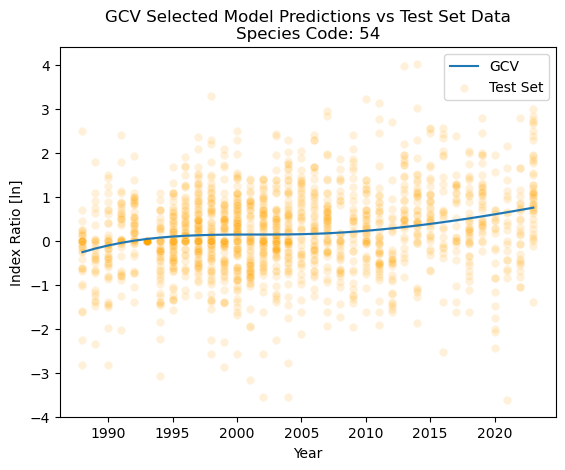

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# The prediction data 
sns.lineplot(x=X_test.ravel(), # .ravel() converts array from 2D to 1D (compatibility)
                y=y_pred_gcv, # y already 1D array
            label='GCV') # enter suitable legend here

# The X_test explanatory data is overlayed, to assess the fit of the model
sns.scatterplot(x=X_test.ravel(),
                y=y_test,
                color='orange',
               alpha=0.15,
               label='Test Set') # enter suitable legend here

# Adding Title
plt.title('GCV Selected Model Predictions vs Test Set Data' 
          + '\n' 
          + 'Species Code: ' 
          + str(species_data.iloc[0,2])) # species code is stored in 'species_data' df

# Labelling the x and y axis
plt.xlabel('Year')
plt.ylabel('Index Ratio [ln]')

#### 2) AIC Optimisation

AIC = -2(Log Likelihood) + 2(edof)

AIC rewards models with a higher log likelihood. This is the summed probability of
all the residuals being observed by the model. 

Models with greater predictive power will produce smaller residuals that tend towards the centre of the probability
denisty function, achieving higher probabilities, and a larger log likelihood. 

Similar to GCV, models with greater complexity (edof) will lead to higher AIC scores assuming the other variables remain constant.

In [ ]:
# The training data and input parameters are added
# To overide the default GCV criteria, the 'objective' argument is set to 'AIC'
model_aic = (
    LinearGAM(s(0))
    .gridsearch(X_train, y_train, lam=lam, n_splines=splines, objective='AIC')
)

# A summary of the optimal model parameters and edof using AIC.
print('AIC optimal parameters: ', '\n',
      'lambda:', model_aic.lam[0][0], '\n',
      'spline count:', model_aic.n_splines[0], '\n',
     'edof: ', model_aic.statistics_['edof'])

100% (60 of 60) |########################| Elapsed Time: 0:00:02 Time:  0:00:020000


AIC optimal parameters:  
 lambda: 0.0727895384398315 
 spline count: 5 
 edof:  4.8144190407888745


In [11]:
# Using the AIC optimised model and test set explanantory data to predict 'y_pred_aic'
y_pred_aic = model_aic.predict(X_test)

#### Visualising the AIC Model Test Set Predictions

Text(0, 0.5, 'Index Ratio [ln]')

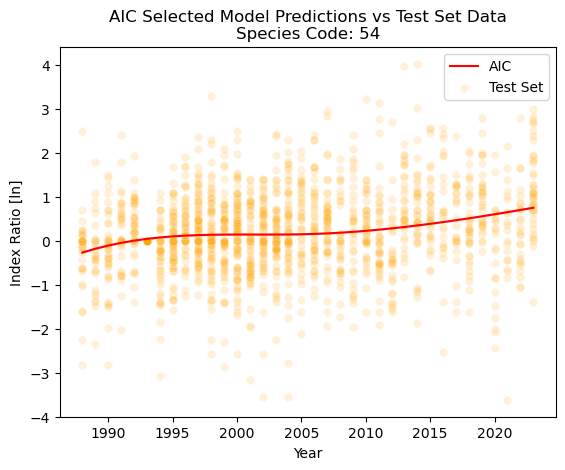

In [12]:
# The prediction data
sns.lineplot(x=X_test.ravel(), # .ravel() converts array from 2D to 1D (compatibility)
                y=y_pred_aic, # y already 1D array
            color='red',
            label='AIC') # enter suitable legend here

# The test set data (explanatory data) is overlayed, to assess the fit of the model
sns.scatterplot(x=X_test.ravel(), 
                y=y_test,
                color='orange',
               alpha=0.15,
               label='Test Set') # enter suitable legend here

# Adding Title
plt.title('AIC Selected Model Predictions vs Test Set Data' 
          + '\n' 
          + 'Species Code: ' 
          + str(species_data.iloc[0,2])) # species code is stored in 'species_data' df

# Labelling the x and y axis
plt.xlabel('Year')
plt.ylabel('Index Ratio [ln]')

#### 3) BIC Optimisation

BIC = -2*Log Likelihood + ln(n)*edof (where n=sample size)

The same as AIC, but 2 in the penalty term is replaced with ln(n). For all practical cases, this results in a relatively larger penalty for complex models. 

BIC therefore places greater emphasis on simplicity, and less on predictive power compared with AIC. 

In [ ]:
# BIC is not available in gridsearch.
# Hence, a manual optimisiation for BIC is constructed here by looping parameter 
# combinations.
# 'product' is used to create an iterator for all combinations of the input parameters
from itertools import product
combinations = product(lam, splines) 

# Empty lists are created for the model input parameters and output metrics of interest. 
lam_list = [] 
spline_list = [] 
bic = [] 
edof = [] 
for lam, splines in combinations: # Each loop uses a different parameter combination
    # The training data and input parameters are added (lambda and spline count)
    model_bic_train = LinearGAM(s(0), lam=lam, n_splines=splines).fit(X_train, y_train)
    # Model lambda value is added to list using '.append()'
    lam_list.append(model_bic_train.lam[0][0]) 
    # Model spline count is added to list
    spline_list.append(model_bic_train.n_splines[0]) 
    # For each loop BIC is calculated manually and added to the outer 'bic' list. 
    # '.statistics_' is used to access the model edof and loglikelihood.
    bic.append((-2*model_bic_train.statistics_['loglikelihood']) 
               + (np.log(len(y_train))*model_bic_train.statistics_['edof']))
    edof.append(model_bic_train.statistics_['edof'])

In [14]:
# lam_list, spline_list, edof and bic are joined into a dataframe: 'model_parameters'
model_parameters = pd.DataFrame({'lam':lam_list,
                                 'splines':spline_list,
                                 'bic':bic,
                                 'edof':edof})    

In [15]:
# Extracting the optimal model parameters according to BIC.
min_bic = model_parameters['bic'].min() # extracting the min BIC score

# 'model_parameters' is filtered using 'min_bic'.
# Subsetting is then used to extract the correct parameter
bic_lam = (
    round(model_parameters[model_parameters['bic']==min_bic] 
          .iloc[0,0],5) # 1st row of the filtered lambda column.
)

bic_splines = (
    model_parameters[model_parameters['bic']==min_bic]
    .iloc[0,1] # 1st row of the filtered splines column.
)

bic_edof = (
    model_parameters[model_parameters['bic']==min_bic]
    .iloc[0,3] # 1st row of the filtered edof column.
)

# A summary of the optimal model parameters and edof using AIC.
print('BIC optimal parameters:', '\n'
      'lambda:', bic_lam, '\n',
      'spline count:', bic_splines, '\n',
     'edof: ', bic_edof)

BIC optimal parameters: 
lambda: 0.78805 
 spline count: 5 
 edof:  4.056438181987055


In [16]:
# Using the parameters selected from the BIC model optimisation to fit the model
model_bic_opt = (
    LinearGAM(s(0), lam=bic_lam, n_splines=bic_splines)
    .fit(X_train, y_train)
)

# Using the model to predict 'y_pred_bic'
y_pred_bic = model_bic_opt.predict(X_test)

#### Visualising the BIC Model Test Set Predictions

Text(0, 0.5, 'Index Ratio [ln]')

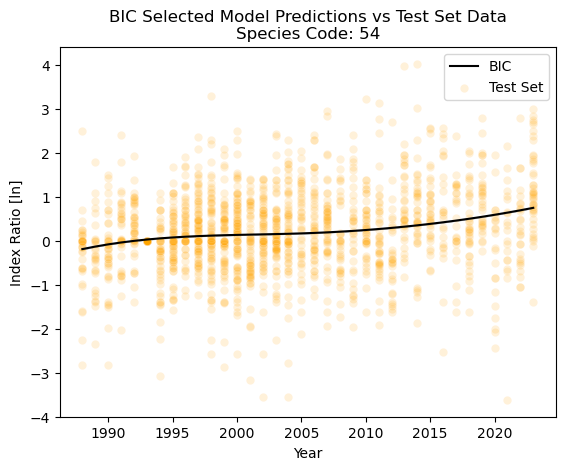

In [17]:
# The prediction data
sns.lineplot(x=X_test.ravel(), # .ravel() converts array from 2D to 1D (compatibility)
                y=y_pred_bic, # y already 1D array
            color='black',
            label='BIC') # enter suitable legend here

# The test set data (explanatory data) is overlayed, to assess the fit of the model
sns.scatterplot(x=X_test.ravel(), 
                y=y_test,
                color='orange',
               alpha=0.15,
               label='Test Set') # enter suitable legend here

# Adding title
plt.title('BIC Selected Model Predictions vs Test Set Data' 
          + '\n' 
          + 'Species Code: ' 
          + str(species_data.iloc[0,2])) # species code is stored in 'species_data' df

# Labelling the x and y axis
plt.xlabel('Year')
plt.ylabel('Index Ratio [ln]')

#### Visual Comparison of GCV, AIC and BIC Selected Model Predictions (Log Form)
The optimised predictions for GCV, AIC and BIC are overlayed for comparison.

Text(0, 0.5, 'Index Ratio [ln]')

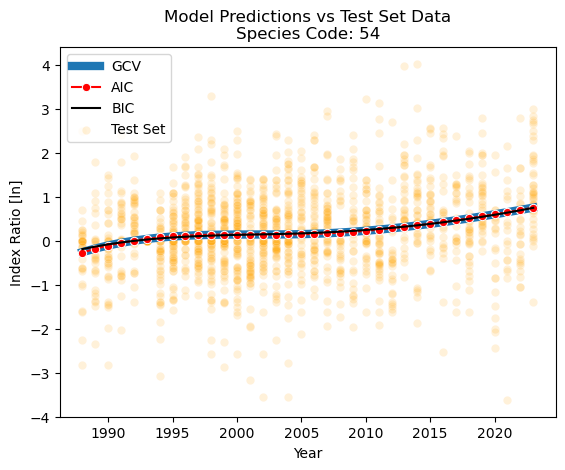

In [18]:
plt.clf()

# GCV predcition data
sns.lineplot(x=X_test.ravel(), # .ravel() converts array from 2D to 1D (compatibility)
                y=y_pred_gcv, # y already 1D array
            linewidth=6, # changes thickness of line in graph. 
            label='GCV')

# AIC predcition data
sns.lineplot(x=X_test.ravel(), 
                y=y_pred_aic,
            color='red',
            marker='o',
            label='AIC')

# BIC predcition data
sns.lineplot(x=X_test.ravel(), 
                y=y_pred_bic,
               color='black',
            label='BIC')

# Test Set Data (explanatory data)
sns.scatterplot(x=X_test.ravel(), 
                y=y_test,
                color='orange',
               alpha=0.15,
               label='Test Set')

# Adding title
plt.title('Model Predictions vs Test Set Data' 
          + '\n' 
          + 'Species Code: ' 
          + str(species_data.iloc[0,2])) # species code is stored in 'species_data' df

# Labelling x and y axis
plt.xlabel('Year')
plt.ylabel('Index Ratio [ln]')

#### Visual Comparison of GCV, AIC and BIC Selected Model Predictions (Back-Transformed)
The optimised predictions for GCV, AIC and BIC are overlayed for comparison.

Text(0, 0.5, 'Index Ratio')

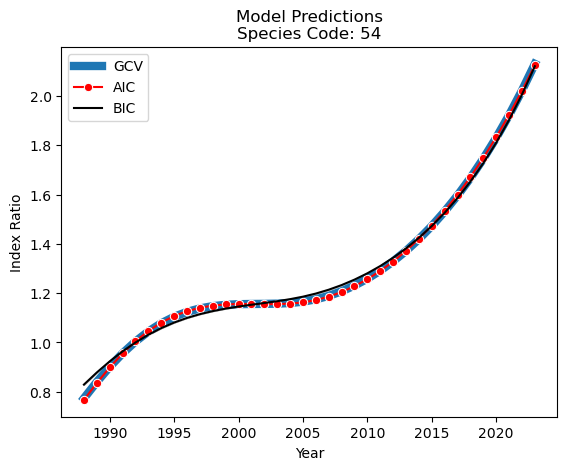

In [19]:
# Visually comparing the three models is difficult on the log scale.
# Here, the log index ratios are back transformed using np.exp()

plt.clf()

# GCV predcition data
sns.lineplot(x=X_test.ravel(), 
                y=np.exp(y_pred_gcv),
            linewidth=6, # changes thickness of line in graph. 
            label='GCV')

# AIC predcition data
sns.lineplot(x=X_test.ravel(), 
                y=np.exp(y_pred_aic),
            color='red',
            marker='o',
            label='AIC')

# BIC predcition data
sns.lineplot(x=X_test.ravel(), 
                y=np.exp(y_pred_bic),
               color='black',
            label='BIC')

# Adding title
plt.title('Model Predictions' 
          + '\n' 
          + 'Species Code: ' 
          + str(species_data.iloc[0,2]))

# Labelling x and y axis
plt.xlabel('Year')
plt.ylabel('Index Ratio')

#### Computation of Performance Metrics

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# The predictions generated by each model selection criteria are saved in a dictionary.
select_method = {'gcv':y_pred_gcv,
                 'aic':y_pred_aic,
                 'bic':y_pred_bic}

# A for loop is used to compute the performance metrics for each model selection method.
# An empty list is created for each metric. The lists become populated using the 
# '.append()' method.
r2_list = [] # r2: coefficient of detrmination
mse_list = [] # mse: mean standard error
mae_list = [] # mae: mean absolute error
rmse_list = [] # rmse: root mean standard error
for i in select_method: # loops through each criteria in 'select_method' dictionary
    r2 = round(r2_score(y_test, select_method[i]),4)
    r2_list.append(r2)
    mse = round(mean_squared_error(y_test, select_method[i]),4)
    mse_list.append(mse)
    mae = round(mean_absolute_error(y_test, select_method[i]),4)
    mae_list.append(mae)
    rmse = round(np.sqrt(mse),4)
    rmse_list.append(rmse)

# The lists are joined into a dataframe, so the 'optimal' performance metrics according
# to each model selection criteria can be compared.
predict_metrics = pd.DataFrame({'select_method':list(select_method.keys()),
                                'r2_score':r2_list,
                                'mae_score':mae_list,
                                'rmse_score':rmse_list})
print(predict_metrics)

  select_method  r2_score  mae_score  rmse_score
0           gcv    0.0502     0.6588      0.9013
1           aic    0.0501     0.6590      0.9014
2           bic    0.0507     0.6573      0.9011


#### Analysis of Performance Metrics

1) MAE and RMSE score:

The difference in scores between the different models is negligible. 

2) Coefficient of Determination (r2):

In this context, r2 is not indicative of a good fit.

r2 score is 1 minus the sum of the squares of the residuals predicted by 
the model, divided by the total sum of the squares. The total sum of the residuals is 
calculated using a mean estimate (a flat line). A score of 1 indicates the model is
able to explain all the variance. A score of 0 suggests the model is unable to explain
any variance in the response variable. 

Hence, if the species trend is 'naturally flat' because species abundance neither 
increased or decreased with time, the r2 score will tend towards 0 even though the 
model appears to 'fit' the data. 

In [22]:
# Now the models need to be checked for bias and distribution of the residuals
# The y_test, y_pred_bic, y_pred_aic and corresponding residuals are added to a new 
# dataframe: 'results'
results = pd.DataFrame({'y_test':y_test,
                        'y_pred_bic':y_pred_bic,
                        'residuals_bic':y_test-y_pred_bic,
                        'y_pred_aic':y_pred_aic,
                        'residuals_aic':y_test-y_pred_aic})

#### Comparing AIC and BIC Models: Fitted Values vs Residuals
This visual is used to determine if a model underpredicts or overpredicts across its 
'fitted range' (predicted values).
The 'lowess line' reveals the trend of the residuals.
Under predictions are seen when the lowess line tracks above the x=0 line. 
Over predictions occur when the lowess line tracks below the x=0 line.
A model without bias, will track perfectly along this line.

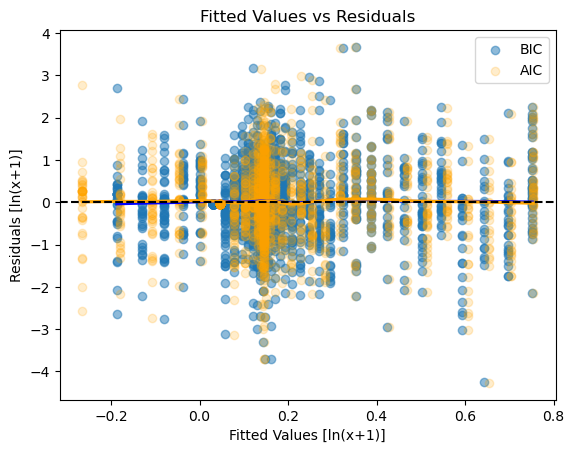

In [ ]:
# The 'lowess' package is required to fit the lowess line
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.clf()

# Plotting fitted vs residual values from the BIC optimised model
sns.regplot(data=results,
           y='residuals_bic', # residuals
           x='y_pred_bic', # predicted values
           lowess=True, # default argument is set to false
            label='BIC',
            scatter_kws={'alpha':0.5}, # colour of the lowess line
           line_kws={'color':'blue'}) # colour of the residual data points

# Plotting fitted vs residual values from the AIC optimised model
sns.regplot(data=results,
           y='residuals_aic', # residuals
           x='y_pred_aic', # predicted values 
           lowess=True, 
             label='AIC',
            scatter_kws={'alpha':0.2, 'color':'orange'},
           line_kws={'color':'orange'})

# For visual reference, an x=0 line is added. 
plt.axline(xy1=(0,0), # the x and y intercept
           slope=0,
           linestyle='--',
           color='black')

# Adding the title
plt.title('Fitted Values vs Residuals')

# Fitting the x and y labels
plt.xlabel('Fitted Values [ln(x+1)]')
plt.ylabel('Residuals [ln(x+1)]')

plt.legend() # required by regplot to add data labels
plt.show()

#### Comparing AIC and BIC Models: Q-Q Plot
The q-q plot is used to compare the distribution of the model residuals against a
normal distribution with the same sample size. The quantiles of the model residuals
are plotted against the residual quantiles of the normal distribtuion.
A perfectly normal distribution is shown when the model residual quantiles track the 
x=y line. When the model tracks below x=y, this indicates that the residual at this 
quantile is less than would be expected assuming a normal distribution.
Tracking above x=y, indicates the residual at this quantile is greater than would be 
expected. 

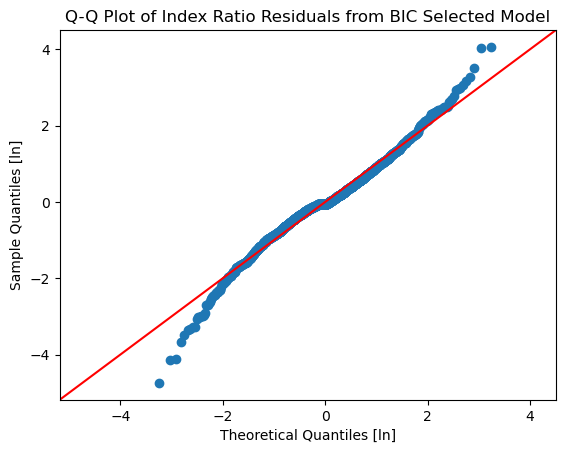

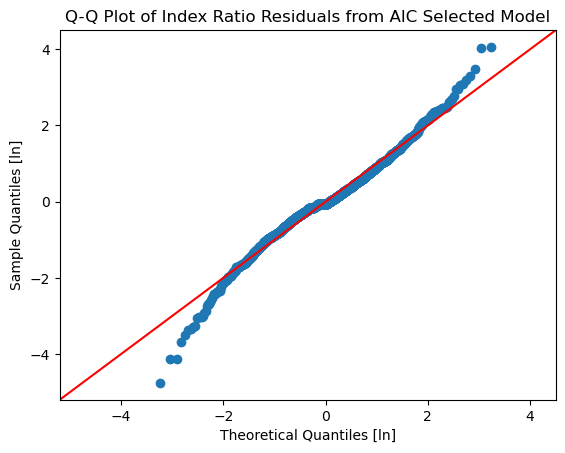

In [25]:
# The 'qqplot' package is used to fit the q-q plot
from statsmodels.api import qqplot

qqplot(data=results.residuals_bic, # The BIC selected model residuals
      fit=True,
      line='45')
# Adding the title 
plt.title('Q-Q Plot of Index Ratio Residuals from BIC Selected Model')
# Adding the x and y labels
plt.xlabel('Theoretical Quantiles [ln]')
plt.ylabel('Sample Quantiles [ln]')

qqplot(data=results.residuals_aic, # The AIC selected model residuals
      fit=True,
      line='45')
# Adding the title
plt.title('Q-Q Plot of Index Ratio Residuals from AIC Selected Model')
# Adding the x and y labels
plt.xlabel('Theoretical Quantiles [ln]')
plt.ylabel('Sample Quantiles [ln]')

plt.show()

#### Conclusion
For species code 54: GCV, AIC and BIC selectors result in similar models with
negligible differences in residual distribution, MAE and RMSE. The smooth is slightly
less complex in the model selected by BIC (edof=4.06) vs AIC (edof=4.81) and GCV 
(edof=4.72), although the difference is minimal. 

Since performance is almost equal in terms of predictive performance and residual
behaviour, a lower edof distinguishes the BIC selected model from the other model 
selectors. Hence BIC is recommended for use in the stage 2  GAM for species code 54. 